# Imports

In [6]:
from pathlib import Path
import pandas as pd
import warnings
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
import matplotlib.gridspec as gridspec

from applefy.detections.contrast import Contrast
from applefy.statistics import TTest, gaussian_sigma_2_fpf, \
    fpf_2_gaussian_sigma
from applefy.utils.file_handling import load_adi_data
from applefy.utils import flux_ratio2mag, mag2flux_ratio
from applefy.utils.photometry import AperturePhotometryMode
from applefy.utils.file_handling import save_as_fits
from applefy.utils.contrast_grid import compute_contrast_from_grid

from s4hci.utils.data_handling import read_s4hci_root_dir
from s4hci.utils.setups import contrast_grid_setup_1
from s4hci.detection_limits.applefy_wrapper import cADIDataReductionGPU, PCADataReductionGPU
from s4hci.detection_limits.applefy_wrapper import S4DataReduction
from s4hci.models.psf_subtraction import S4

# Datasets of interest

In [2]:
# Dataset setups (Name of the dataset, parameter 1, parameter 2)
datasets = [ 
    ("HD22049_310_0100_C-0656_A_", 0.0042560, 0.08, 3.6, 680.2, 1.0),
    ("HD22049_351_096_C-0679_A_", 0.0042560, 0.08, 3.6, 529.2, 1.0),
    ("HD22049_303_199_C-0065_C_", 0.0042560, 0.08, 3.6, 809.6, 1.0)
]

In [3]:
# select one dataset
dataset_name, dit_psf_template, dit_science, fwhm, best_lambda, scaling_factor = datasets[2]
pixel_scale=0.02718

# Load the data

In [7]:
root_dir = Path(read_s4hci_root_dir())

Data in the S4HCI_ROOT_DIR found. Location: /fast/mbonse/s4


In [8]:
dataset_file = root_dir / Path("30_data/" + dataset_name + ".hdf5")
experiment_root_dir = root_dir / Path("70_results/x1_fake_planet_experiments/" + dataset_name)
experiment_root_dir.mkdir(exist_ok=True)

In [9]:
science_data, angles, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag="object_stacked_05",
    psf_template_tag="psf_template",
    para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template_data, axis=0)

In [10]:
# we want the image to show the innermost 1.2 arcsec
print(1.2 / pixel_scale * 2)

88.30022075055187


In [11]:
# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

# Run fake planet experiments for PCA and cADI

In [12]:
contrast_instance = Contrast(
    science_sequence=science_data,
    psf_template=psf_template,
    parang_rad=angles,
    psf_fwhm_radius=fwhm / 2,
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    scaling_factor=scaling_factor, # A factor to account e.g. for ND filters
    checkpoint_dir=experiment_root_dir)

## 1. Design fake planet experiments

In [13]:
# get fake planet setup
flux_ratios, separations, num_fake_planets = contrast_grid_setup_1(fwhm)
print("Brightness of fake planets in mag: " + str(flux_ratio2mag(flux_ratios)))
print("Separations of interest in lambda /D: " + str(separations / fwhm))

Brightness of fake planets in mag: [ 5.   5.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5
 12.  12.5 13.  13.5 14.  14.5 15. ]
Separations of interest in lambda /D: [ 1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.  11.
 12. ]


In [14]:
print("# Grid experiments: " + str(len(separations) * len(flux_ratios) * num_fake_planets))

# Grid experiments: 945


In [15]:
contrast_instance.design_fake_planet_experiments(
    flux_ratios=flux_ratios,
    num_planets=num_fake_planets,
    separations=separations,
    overwrite=True)

Overwriting existing config files.


## 2. Run fake planet experiments for cADI

In [20]:
cadi_algorithm_function = cADIDataReductionGPU(0)

In [ ]:
contrast_instance.run_fake_planet_experiments(
    algorithm_function=cadi_algorithm_function,
    num_parallel=8)

Running fake planet experiments...


 30%|████████████████████████████████████████████████▊                                                                                                                    | 280/946 [06:49<15:14,  1.37s/it]

In [60]:
contrast_instance.results_dict.keys()

dict_keys(['cADI'])

## 3. Run fake planet experiments for PCA

In [61]:
pca_numbers = np.concatenate(
    [np.arange(0, 30, 2)[1:],
     np.arange(30, 100, 10),
     np.arange(100, 200, 20),
     np.arange(200, 550, 50)])

In [62]:
work_dir = contrast_instance.scratch_dir / Path("tensorboard_pca")

In [63]:
pca_algorithm_function = PCADataReductionGPU(
        approx_svd=8000,
        pca_numbers=pca_numbers,
        device=0,
        work_dir=work_dir,
        special_name="stacked_05",
        verbose=False)

In [64]:
old_results = contrast_instance.results_dict
contrast_instance.run_fake_planet_experiments(
    algorithm_function=pca_algorithm_function,
    num_parallel=1)
contrast_instance.results_dict.update(old_results)

Running fake planet experiments...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 946/946 [03:53<00:00,  4.06it/s]

[DONE]


# Compute Contrast Grids for PCA and cADI

In [65]:
# Use apertures pixel values
photometry_mode_planet = AperturePhotometryMode(
    "F",
    psf_fwhm_radius=fwhm/2,
    search_area=0.5)

photometry_mode_noise = AperturePhotometryMode(
    "P",
    psf_fwhm_radius=fwhm/2)

In [66]:
contrast_instance.prepare_contrast_results(
    photometry_mode_planet=photometry_mode_planet,
    photometry_mode_noise=photometry_mode_noise)

In [67]:
statistical_test = TTest()

In [68]:
contrast_grids = contrast_instance.compute_contrast_grids(
    statistical_test=statistical_test,
    num_cores=32,
    num_rot_iter=10,
    compute_snr_grid=True,
    safety_margin=2.5,
    pixel_scale=pixel_scale)

Computing contrast grid for stacked_05_PCA_002_components
Computing contrast grid with multiprocessing:
...........................................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for stacked_05_PCA_004_components
Computing contrast grid with multiprocessing:
...........................................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for stacked_05_PCA_006_components
Computing contrast grid with multiprocessing:
............................................

...........................................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for stacked_05_PCA_090_components
Computing contrast grid with multiprocessing:
...........................................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for stacked_05_PCA_100_components
Computing contrast grid with multiprocessing:
....................................................................................................................................................

## Save mergered PCA residuals

In [24]:
all_residuals = []

for tmp_method_name, tmp_result in contrast_instance.contrast_results.items():
    if not tmp_method_name.startswith("stacked_05_PCA"):
        continue
    all_residuals.append(tmp_result.residuals)

In [81]:
all_residuals = np.array(all_residuals)
save_as_fits(all_residuals, experiment_root_dir / Path("merged_residuals_pca.fits"))

OSError: File /fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/merged_residuals_pca.fits already exists. If you mean to replace it then use the argument "overwrite=True".

# Determine Limits for PCA

## 1. Get the index table for all possible experiments

In [69]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
lookup_table = deepcopy(contrast_instance.contrast_results["stacked_05_PCA_002_components"].idx_table)
lookup_table.columns = flux_ratio2mag(lookup_table.columns)
lookup_table.index = lookup_table.index / 3.6
lookup_table

flux_ratio  5.0   5.5   6.0   6.5   7.0   7.5   8.0   8.5   9.0   9.5   10.0   
separation                                                                     
1.5            1    16    31    46    61    76    91   106   121   136   151  \
2.0            2    17    32    47    62    77    92   107   122   137   152   
2.5            3    18    33    48    63    78    93   108   123   138   153   
3.0            4    19    34    49    64    79    94   109   124   139   154   
3.5            5    20    35    50    65    80    95   110   125   140   155   
4.0            6    21    36    51    66    81    96   111   126   141   156   
4.5            7    22    37    52    67    82    97   112   127   142   157   
5.0            8    23    38    53    68    83    98   113   128   143   158   
6.0            9    24    39    54    69    84    99   114   129   144   159   
7.0           10    25    40    55    70    85   100   115   130   145   160   
8.0           11    26    41    56    71    86   101   116   131   146   161   
9.0           12    27    42    57    72    87   102   117   132   147   162   
10.0          13    28    43    58    73    88   103   118   133   148   163   
11.0          14    29    44    59    74    89   104   119   134   149   164   
12.0          15    30    45    60    75    90   105   120   135   150   165   

flux_ratio  10.5  11.0  11.5  12.0  12.5  13.0  13.5  14.0  14.5  15.0  
separation                                                              
1.5          166   181   196   211   226   241   256   271   286   301  
2.0          167   182   197   212   227   242   257   272   287   302  
2.5          168   183   198   213   228   243   258   273   288   303  
3.0          169   184   199   214   229   244   259   274   289   304  
3.5          170   185   200   215   230   245   260   275   290   305  
4.0          171   186   201   216   231   246   261   276   291   306  
4.5          172   187   202   217   232   247   262   277   292   307  
5.0          173   188   203   218   233   248   263   278   293   308  
6.0          174   189   204   219   234   249   264   279   294   309  
7.0          175   190   205   220   235   250   265   280   295   310  
8.0          176   191   206   221   236   251   266   281   296   311  
9.0          177   192   207   222   237   252   267   282   297   312  
10.0         178   193   208   223   238   253   268   283   298   313  
11.0         179   194   209   224   239   254   269   284   299   314  
12.0         180   195   210   225   240   255   270   285   300   315

## 2. Get the overall best results of PCA

In [70]:
baseline_grids = deepcopy(contrast_grids)
del baseline_grids["cADI"]

all_grids = np.array(
    [tmp_grid.values
     for tmp_grid in baseline_grids.values()])

over_all_best = deepcopy(contrast_grids["stacked_05_PCA_002_components"])
over_all_best.iloc[:, :] = np.max(all_grids, axis=0)
over_all_best.index = flux_ratio2mag(over_all_best.index)

## 3. Plot the overall best PCA

In [71]:
def plot_contrast_grid(
    contrast_grid_axis,
    colorbar_axis,
    contrast_grid):

    c_bar_kargs = dict(
        orientation = "vertical",
        label = r"SNR [$T_{obs}$]")

    heat = sns.heatmap(
        contrast_grid,
        vmax=2, vmin=7,
        annot=True,
        cmap="YlGnBu",
        ax=contrast_grid_axis,
        cbar_ax=colorbar_axis,
        cbar_kws=c_bar_kargs)

    ylabels = ['{:.1f}'.format(float(x.get_text()))
               for x in heat.get_yticklabels()]
    _=heat.set_yticklabels(ylabels)
    xlabels = ['{:.1f}'.format(float(x.get_text()))
               for x in heat.get_xticklabels()]
    _=heat.set_xticklabels(xlabels)

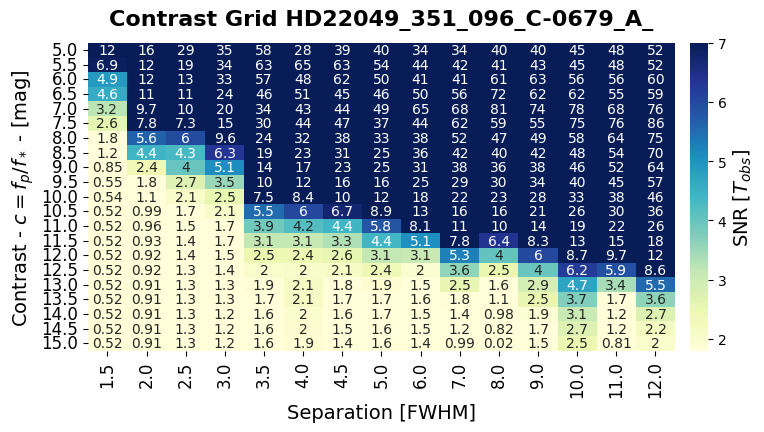

In [72]:
fig = plt.figure(figsize=(8, 4))

gs0 = fig.add_gridspec(1, 1)
gs0.update(wspace=0.0, hspace=0.2)
gs1 = gridspec.GridSpecFromSubplotSpec(
    1, 2, subplot_spec = gs0[0],
    wspace=0.05, width_ratios=[1, 0.03])

# All axis we need
contrast_ax = fig.add_subplot(gs1[0])
colorbar_ax = fig.add_subplot(gs1[1])

# Plot the contrast grid
plot_contrast_grid(
    contrast_grid_axis=contrast_ax,
    colorbar_axis=colorbar_ax,
    contrast_grid=over_all_best)

colorbar_ax.yaxis.label.set_size(14)

contrast_ax.set_ylabel(
    "Contrast - $c = f_p / f_*$ - [mag]", size=14)
contrast_ax.set_xlabel(
    r"Separation [FWHM]", size=14)
contrast_ax.set_title(
    "Contrast Grid " + dataset_name,
    fontsize=16,
    fontweight="bold",
    y=1.03)

contrast_ax.tick_params(
    axis='both',
    which='major',
    labelsize=12)

# Save the figure
fig.patch.set_facecolor('white')

## 3. Select the $S^4$ experiments we want to run

In [73]:
distance_from_8 = (over_all_best - 8.0).abs().values
minima_upper = np.argmin(distance_from_8, axis=0)

upper = lookup_table.columns[minima_upper].values
lower = deepcopy(upper)

# we expect better results close in. Thus, we compute residuals for fainter fake planets close in
lower[0:6] += 7/2
lower[6:] += 4/2

In [78]:
lower

array([ 9. , 11. , 11. , 11.5, 13.5, 13.5, 12.5, 12.5, 13. , 13.5, 13.5,
       13.5, 14. , 14. , 14.5])

In [75]:
upper

array([ 5.5,  7.5,  7.5,  8. , 10. , 10. , 10.5, 10.5, 11. , 11.5, 11.5,
       11.5, 12. , 12. , 12.5])

# Run $S^4$

## 1. Create file with all experiments to run

In [79]:
selection_file = experiment_root_dir.parent / Path("S4_" + dataset_name + ".txt")

In [80]:
don_t_use = []
with open(selection_file, "w") as text_file:
    text_file.write(dataset_name + " " + "0000\n")
    
    for idx_sep, tmp_separation in enumerate(lookup_table.index):
        for tmp_flux_ratio in lookup_table.columns:
            current_idx = lookup_table[float(tmp_flux_ratio)][tmp_separation]

            if (tmp_flux_ratio <= lower[idx_sep]) & (tmp_flux_ratio >= upper[idx_sep]):              
                
                for planet_name in ["a", "b", "c"]:
                    text_file.write(dataset_name + " " + str(current_idx).zfill(4) + planet_name + "\n")
                
            else:
                don_t_use.append(str(current_idx).zfill(4) + "a")
                don_t_use.append(str(current_idx).zfill(4) + "b")
                don_t_use.append(str(current_idx).zfill(4) + "c")

## 2. Run the jobs on the cluster

See separate script.

## 3. Create empty residuals for the experiments we did not run

In [96]:
dummy_image = np.ones_like(science_data[0])
method_names = ["s4_mean", "s4_median"]

In [97]:
for tmp_method_name in method_names:    
    for tmp_exp_id in don_t_use:
        tmp_file = experiment_root_dir / Path("residuals") \
            / Path(tmp_method_name) / Path("residual_ID_" + tmp_exp_id + ".fits")
        
        print(tmp_file)
        if not tmp_file.is_file():            
            save_as_fits(dummy_image, str(tmp_file))

/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0001a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0001b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0001c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0016a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0016b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0016c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0121a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0121b.fits
/fast/mbonse/s4/70_results/x1_fa

/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0242b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0242c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0257a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0257b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0257c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0272a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0272b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0272c.fits
/fast/mbonse/s4/70_results/x1_fa

/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0094a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0094b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0094c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0199a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0199b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0199c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0214a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0214b.fits
/fast/mbonse/s4/70_results/x1_fa

/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0021c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0036a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0036b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0036c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0051a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0051b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0051c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0066a.fits
/fast/mbonse/s4/70_results/x1_fa

/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0247b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0247c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0262a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0262b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0262c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0277a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0277b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0277c.fits
/fast/mbonse/s4/70_results/x1_fa

/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0069a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0069b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0069c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0084a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0084b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0084c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0099a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0099b.fits
/fast/mbonse/s4/70_results/x1_fa

/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0190c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0205a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0205b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0205c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0280a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0280b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0280c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0295a.fits
/fast/mbonse/s4/70_results/x1_fa

/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0027b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0027c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0042a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0042b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0042c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0057a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0057b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0057c.fits
/fast/mbonse/s4/70_results/x1_fa

/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0163a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0163b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0163c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0178a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0178b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0178c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0193a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0193b.fits
/fast/mbonse/s4/70_results/x1_fa

/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0030c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0045a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0045b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0045c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0060a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0060b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0060c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_mean/residual_ID_0075a.fits
/fast/mbonse/s4/70_results/x1_fa

/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0241b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0241c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0256a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0256b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0256c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0271a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0271b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0271c.fits
/fast/mbonse/s4/

/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0183a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0183b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0183c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0198a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0198b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0198c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0213a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0213b.fits
/fast/mbonse/s4/

/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0020c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0035a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0035b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0035c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0050a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0050b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0050c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0065a.fits
/fast/mbonse/s4/

/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0276b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0276c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0291a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0291b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0291c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0306a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0306b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0306c.fits
/fast/mbonse/s4/

/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0098a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0098b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0098c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0113a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0113b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0113c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0128a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0128b.fits
/fast/mbonse/s4/

/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0279c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0294a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0294b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0294c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0309a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0309b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0309c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0010a.fits
/fast/mbonse/s4/

/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0101b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0101c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0116a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0116b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0116c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0131a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0131b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0131c.fits
/fast/mbonse/s4/

/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0297a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0297b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0297c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0312a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0312b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0312c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0013a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0013b.fits
/fast/mbonse/s4/

/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0104c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0119a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0119b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0119c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0134a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0134b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0134c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0149a.fits
/fast/mbonse/s4/

/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0240a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0240b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0240c.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0255a.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0255b.fits
/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/residuals/s4_median/residual_ID_0255c.fits


# Restore $S^4$ results from the cluster

In [23]:
s4_model = S4DataReduction(
    device=0,
    lambda_reg=best_lambda,
    rotation_grid_down_sample=1,
    logging_interval=50,
    save_models=True,
    train_num_epochs=500,
    noise_cut_radius_psf=1.5*fwhm,
    noise_mask_radius=fwhm,
    work_dir=None,
    verbose=False)

old_results = contrast_instance.results_dict
contrast_instance.run_fake_planet_experiments(
    algorithm_function=s4_model,
    num_parallel=1)
contrast_instance.results_dict.update(old_results)

Running fake planet experiments...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 946/946 [00:13<00:00, 68.95it/s]

[DONE]


# Compute the contrast grids with $S^4$

In [22]:
contrast_instance.prepare_contrast_results(
    photometry_mode_planet=photometry_mode_planet,
    photometry_mode_noise=photometry_mode_noise)

In [23]:
statistical_test = TTest()

In [ ]:
contrast_grids = contrast_instance.compute_contrast_grids(
    statistical_test=statistical_test,
    num_cores=32,
    num_rot_iter=10,
    compute_snr_grid=True,
    safety_margin=2.5,
    pixel_scale=pixel_scale)

Computing contrast grid for stacked_05_PCA_002_components
Computing contrast grid with multiprocessing:
...........................................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for stacked_05_PCA_004_components
Computing contrast grid with multiprocessing:
...........................................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for stacked_05_PCA_006_components
Computing contrast grid with multiprocessing:
............................................

...........................................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for stacked_05_PCA_090_components
Computing contrast grid with multiprocessing:
...........................................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for stacked_05_PCA_100_components
Computing contrast grid with multiprocessing:
....................................................................................................................................................

# Save the $S^4$ residuals

In [102]:
# S4
s4_residuals_mean = contrast_instance.contrast_results["s4_mean"].residuals
s4_residuals_median = contrast_instance.contrast_results["s4_median"].residuals

save_as_fits(s4_residuals_mean, experiment_root_dir / 
             Path("merged_residuals_s4_mean_" + dataset_name + ".fits"))

save_as_fits(s4_residuals_median, experiment_root_dir / 
             Path("merged_residuals_s4_median_" + dataset_name + "_C.fits"))

# Get the S/N = 5 limits

## 1. Threshold the contrast grids for PCA

In [30]:
pca_numbers = np.concatenate(
    [np.arange(0, 30, 2)[1:],
     np.arange(30, 100, 10),
     np.arange(100, 200, 20),
     np.arange(200, 550, 50)])

In [31]:
pca_results = dict()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for tmp_pca_number in pca_numbers:
        tmp_contrast_grid = contrast_grids["stacked_05_PCA_" + str(tmp_pca_number).zfill(3) + "_components"]
        tmp_contrast_grid_fpf = tmp_contrast_grid.applymap(gaussian_sigma_2_fpf)
        tmp_contrast_curve = compute_contrast_from_grid(
            tmp_contrast_grid_fpf.fillna(1e-2), 
            gaussian_sigma_2_fpf(5))
        pca_results[tmp_pca_number] = tmp_contrast_curve.applymap(flux_ratio2mag)

In [32]:
overall_best_pca = np.max(np.array([i.fillna(0) for i in pca_results.values()])[:, :, 0], axis=0)

## 2. Threshold the contrast for $S^4$

In [33]:
s4_median_contrast_grid = contrast_grids["s4_median"]
s4_median_contrast_grid_fpf = s4_median_contrast_grid.applymap(gaussian_sigma_2_fpf)
s4_median_contrast_curve = compute_contrast_from_grid(
    s4_median_contrast_grid_fpf.fillna(1e-2), 
    gaussian_sigma_2_fpf(5))
s4_median_contrast_curve = s4_median_contrast_curve.applymap(flux_ratio2mag)

KeyError: 's4_median'

# Plot the results

In [36]:
# Maybe in separate notebooks for each subplot

In [40]:
separations_FWHM = np.round(contrast_grids[
    "stacked_05_PCA_002_components"].index, 2)
separations_arcsec = contrast_instance.contrast_results[
    "stacked_05_PCA_002_components"].idx_table.index * pixel_scale

In [41]:
# Find one color for each number of PCA components used.
colors = sns.color_palette("rocket_r", 
    n_colors=len(pca_results))
colors

[(0.97628674, 0.87986189, 0.8057883),
 (0.97169389, 0.83320847, 0.73716071),
 (0.96850919, 0.79222565, 0.6764046),
 (0.96612013, 0.74451182, 0.60871954),
 (0.96504223, 0.7015636, 0.5528892),
 (0.96403203, 0.65122535, 0.4932578),
 (0.96276513, 0.60612062, 0.44471698),
 (0.96042097, 0.55328624, 0.39319057),
 (0.9573439, 0.50573243, 0.35130912),
 (0.9524044, 0.44944853, 0.3072105),
 (0.94625977, 0.39813168, 0.27489742),
 (0.93599076, 0.33703942, 0.24972157),
 (0.92223947, 0.28287251, 0.24229568),
 (0.8985026, 0.22463251, 0.25108745),
 (0.87079129, 0.17982114, 0.26797378),
 (0.83355779, 0.13511035, 0.29057852),
 (0.79085854, 0.10184672, 0.313391),
 (0.74919318, 0.08820542, 0.33107204),
 (0.69803757, 0.08897226, 0.3462986),
 (0.65154562, 0.09680192, 0.35454107),
 (0.59770215, 0.10693774, 0.35838029),
 (0.5506426, 0.11420757, 0.35737863),
 (0.49742847, 0.11955087, 0.35206533),
 (0.45158266, 0.12158557, 0.34406324),
 (0.40002537, 0.12134964, 0.33102734),
 (0.355676, 0.11910909, 0.31620996),
 (0.30592213, 0.11432553, 0.29542718),
 (0.26326851, 0.1081815, 0.27401148),
 (0.21560818, 0.09882993, 0.24611154),
 (0.17489524, 0.08848235, 0.2190294),
 (0.12938228, 0.07383015, 0.18636053),
 (0.09011319, 0.05808059, 0.15797687),
 (0.04447016, 0.03648425, 0.12631831)]

NameError: name 'colors' is not defined

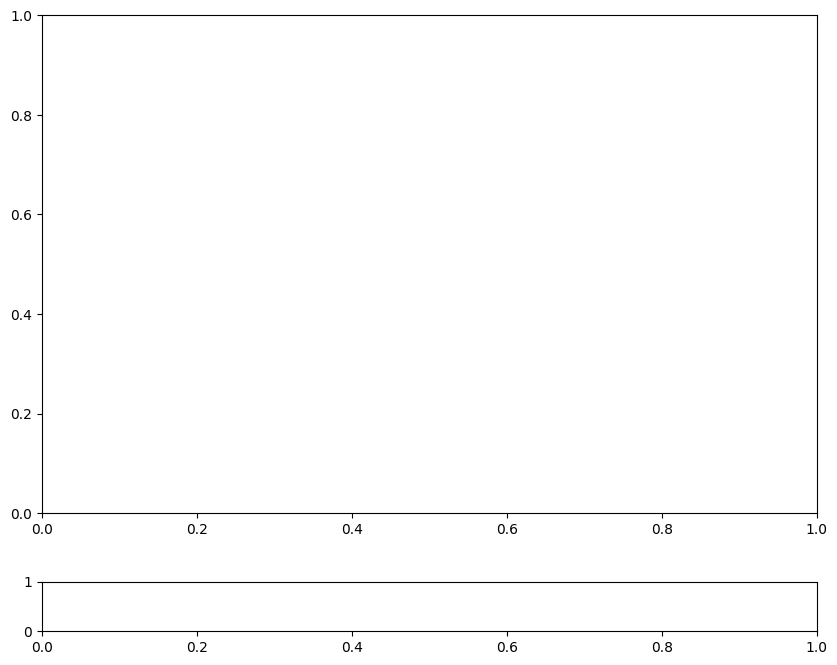

In [34]:
# 1.) Create Plot Layout
fig = plt.figure(constrained_layout=False, figsize=(10, 8))
gs0 = fig.add_gridspec(2, 1, height_ratios=[1, 0.1], hspace=0.25)
axis_contrast_curvse = fig.add_subplot(gs0[0, 0])

# ------------------- Create the PCA number legend -----------
axis_legend_lines = fig.add_subplot(gs0[1, 0])

for idx, tmp_components in enumerate(pca_results.keys()):
    if tmp_components < 20:
        lw=3
    elif tmp_components < 100:
        lw=12
    elif tmp_components < 200:
        lw=24
    else:
        lw=57
    axis_legend_lines.vlines(
        [tmp_components], 
        ymin=0, ymax=1, color=colors[idx],
        lw=lw)
    
axis_legend_lines.set_xlim(0, 500)
axis_legend_lines.set_ylim(0, 1)
axis_legend_lines.set_yticks([])
axis_legend_lines.tick_params(
    axis='both', which='major', labelsize=14)

axis_legend_lines.set_xlabel("Number of PCA components", size=16)


# ---------------------- Create the PCA plots --------------------
i = 0 # color picker

for pca_number, tmp_contrast_mag in pca_results.items():
    axis_contrast_curvse.plot(
        separations_arcsec,
        mag2flux_ratio(tmp_contrast_mag),
        color = colors[i],
        lw=2,
        alpha=0.7)
    i+=1

axis_contrast_curvse.set_yscale("log")

# ----------- Plot the best PCA contrast -------------------------
pca_plot = axis_contrast_curvse.plot(
    separations_arcsec,
    mag2flux_ratio(overall_best_pca),
    color = "black",
    lw=2.5,
    label="PCA (best)",
    ls="dashed")

# ----------- Plot the raw contrast -------------------------
# TODO: add later

# ----------- Plot the S4 contrast --------------------------
s4_plot = axis_contrast_curvse.plot(
    separations_arcsec,
    mag2flux_ratio(s4_median_contrast_curve),
    color = "black",
    lw=2.5,
    label="$S^4$",
    ls="-")

# ------------- Double axis and limits -----------------------
lim_mag_y = (14, 6)
lim_arcsec_x = (0.1, 1.2)

sep_lambda_arcse = interpolate.interp1d(
    separations_arcsec,
    separations_FWHM,
    fill_value='extrapolate')

axis_contrast_curvse_mag = axis_contrast_curvse.twinx()
axis_contrast_curvse_mag.plot(
    separations_arcsec,
    s4_median_contrast_curve,
    alpha=0.)
axis_contrast_curvse_mag.invert_yaxis()

axis_contrast_curvse_lambda = axis_contrast_curvse.twiny()
axis_contrast_curvse_lambda.plot(
    separations_FWHM,
    mag2flux_ratio(s4_median_contrast_curve),
    alpha=0.)

axis_contrast_curvse.grid(which='both')
axis_contrast_curvse_mag.set_ylim(*lim_mag_y)
axis_contrast_curvse.set_ylim(
    mag2flux_ratio(lim_mag_y[0]),
    mag2flux_ratio(lim_mag_y[1]))

axis_contrast_curvse.set_xlim(
    *lim_arcsec_x)
axis_contrast_curvse_mag.set_xlim(
    *lim_arcsec_x)
axis_contrast_curvse_lambda.set_xlim(
    *sep_lambda_arcse(lim_arcsec_x))

# ----------- Labels and fontsizes --------------------------

axis_contrast_curvse.set_xlabel(
    r"Separation [arcsec]", size=16)
axis_contrast_curvse_lambda.set_xlabel(
    r"Separation [$\lambda /D$]", size=16)

axis_contrast_curvse.set_ylabel(
    r"Planet-to-star flux ratio", size=16)
axis_contrast_curvse_mag.set_ylabel(
    r"$\Delta$ Magnitude", size=16)

axis_contrast_curvse.tick_params(
    axis='both', which='major', labelsize=14)
axis_contrast_curvse_lambda.tick_params(
    axis='both', which='major', labelsize=14)
axis_contrast_curvse_mag.tick_params(
    axis='both', which='major', labelsize=14)

axis_contrast_curvse_mag.set_title(
    r"$S/N = 5$ Limits - " + dataset_name[:-1],
    fontsize=18, y=1.13) #fontweight="bold",

# --------------------------- Legend -----------------------
handles, labels = axis_contrast_curvse.\
    get_legend_handles_labels()

# Create a legend with grouped markers and line plot
legend_elements = [
    handles[0],
    handles[1]]

leg1 = fig.legend(legend_elements, labels,
                  bbox_to_anchor=(0.14, 0.26),
                  fontsize=14,
                  handler_map={tuple: HandlerTuple(ndivide=None, pad=1.7)},
                  loc='lower left', ncol=3)

_=plt.setp(leg1.get_title(),fontsize=14)
# plt.savefig("PCA_vs_S4_" + dataset_name + ".pdf", bbox_inches='tight')

In [35]:
plt.plot(separations_FWHM, (s4_median_contrast_curve.values[:, 0] - overall_best_pca))
plt.grid()
plt.xlim(1.2, 12.2)
plt.ylim(-0.5, 1.7)
plt.xlabel("separation [$\lambda /D$]", fontsize=12)
plt.ylabel("improvement in contrast [mag]", fontsize=12)
plt.title("PCA vs. $S^4$ ", fontsize=14)
#plt.savefig("PCA_vs_S4_" + dataset_name + "_relative.pdf", bbox_inches='tight')

NameError: name 'separations_FWHM' is not defined

# Plot different contrast grids

In [42]:
def plot_contrast_grid(
    contrast_grid_axis,
    colorbar_axis,
    contrast_grid):

    c_bar_kargs = dict(
        orientation = "vertical",
        label = r"SNR [$T_{obs}$]")

    heat = sns.heatmap(
        contrast_grid,
        vmax=2, vmin=7,
        annot=True,
        cmap="YlGnBu",
        ax=contrast_grid_axis,
        cbar_ax=colorbar_axis,
        cbar_kws=c_bar_kargs)

    ylabels = ['{:.1f}'.format(float(x.get_text()))
               for x in heat.get_yticklabels()]
    _=heat.set_yticklabels(ylabels)
    xlabels = ['{:.1f}'.format(float(x.get_text()))
               for x in heat.get_xticklabels()]
    _=heat.set_xticklabels(xlabels)

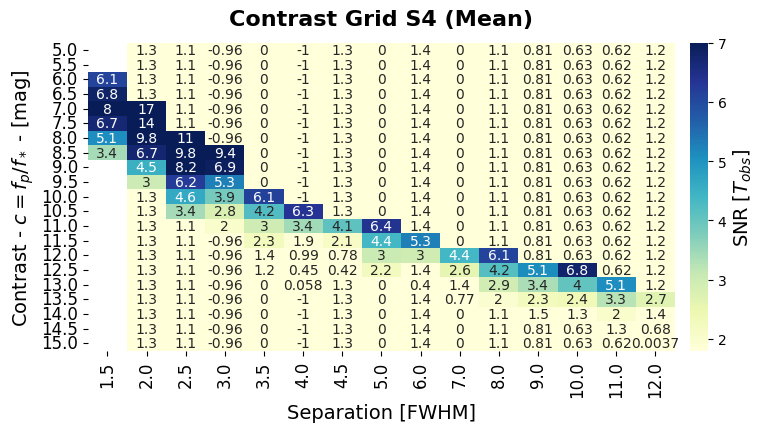

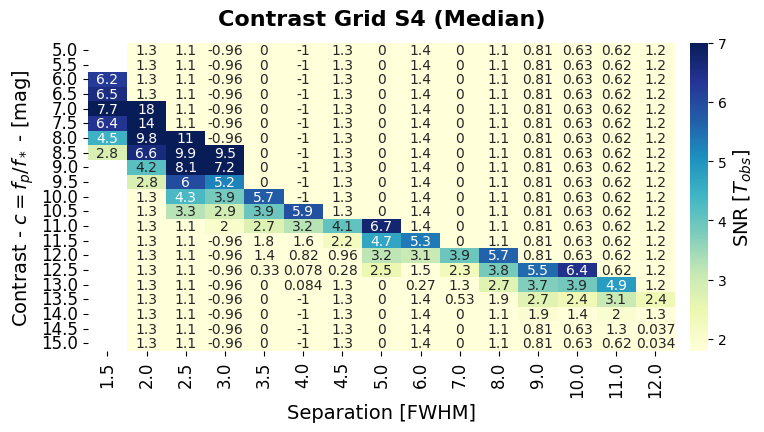

In [40]:
for tmp_model, model_name in [
    ("s4_mean", "(Mean)"),
    ("s4_median", "(Median)"),]:

    s4_contrast_grid = deepcopy(contrast_grids[tmp_model])
    s4_contrast_grid.index = flux_ratio2mag(s4_contrast_grid.index)
    #s4_contrast_grid = s4_contrast_grid.applymap(fpf_2_gaussian_sigma)

    fig = plt.figure(figsize=(8, 4))

    gs0 = fig.add_gridspec(1, 1)
    gs0.update(wspace=0.0, hspace=0.2)
    gs1 = gridspec.GridSpecFromSubplotSpec(
        1, 2, subplot_spec = gs0[0],
        wspace=0.05, width_ratios=[1, 0.03])

    # All axis we need
    contrast_ax = fig.add_subplot(gs1[0])
    colorbar_ax = fig.add_subplot(gs1[1])

    # Plot the contrast grid
    plot_contrast_grid(
        contrast_grid_axis=contrast_ax,
        colorbar_axis=colorbar_ax,
        contrast_grid=s4_contrast_grid)

    colorbar_ax.yaxis.label.set_size(14)

    contrast_ax.set_ylabel(
        "Contrast - $c = f_p / f_*$ - [mag]", size=14)
    contrast_ax.set_xlabel(
        r"Separation [FWHM]", size=14)
    contrast_ax.set_title(
        "Contrast Grid S4 " + model_name,
        fontsize=16,
        fontweight="bold",
        y=1.03)

    contrast_ax.tick_params(
        axis='both',
        which='major',
        labelsize=12)

    # Save the figure
    fig.patch.set_facecolor('white')

In [59]:
baseline_grids = deepcopy(contrast_grids)

special_names = ["s4_mean", 
                 "s4_median",
                 "cADI"]
for special_name in special_names:
    if special_name in baseline_grids:
        del baseline_grids[special_name]
    
baseline_grids.keys()

dict_keys(['stacked_05_PCA_002_components', 'stacked_05_PCA_004_components', 'stacked_05_PCA_006_components', 'stacked_05_PCA_008_components', 'stacked_05_PCA_010_components', 'stacked_05_PCA_012_components', 'stacked_05_PCA_014_components', 'stacked_05_PCA_016_components', 'stacked_05_PCA_018_components', 'stacked_05_PCA_020_components', 'stacked_05_PCA_022_components', 'stacked_05_PCA_024_components', 'stacked_05_PCA_026_components', 'stacked_05_PCA_028_components', 'stacked_05_PCA_030_components', 'stacked_05_PCA_040_components', 'stacked_05_PCA_050_components', 'stacked_05_PCA_060_components', 'stacked_05_PCA_070_components', 'stacked_05_PCA_080_components', 'stacked_05_PCA_090_components', 'stacked_05_PCA_100_components', 'stacked_05_PCA_120_components', 'stacked_05_PCA_140_components', 'stacked_05_PCA_160_components', 'stacked_05_PCA_180_components', 'stacked_05_PCA_200_components', 'stacked_05_PCA_250_components', 'stacked_05_PCA_300_components', 'stacked_05_PCA_350_components',

In [60]:
all_grids = np.array([tmp_grid.values #.applymap(fpf_2_gaussian_sigma)
                      for tmp_grid in baseline_grids.values()])

In [61]:
over_all_best = deepcopy(contrast_grids["stacked_05_PCA_002_components"])
over_all_best.iloc[:, :] = np.max(all_grids, axis=0)
over_all_best.index = flux_ratio2mag(over_all_best.index)

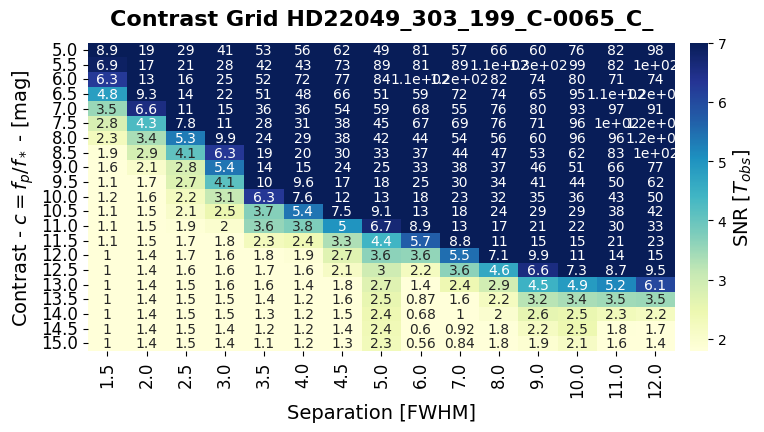

In [62]:
fig = plt.figure(figsize=(8, 4))

gs0 = fig.add_gridspec(1, 1)
gs0.update(wspace=0.0, hspace=0.2)
gs1 = gridspec.GridSpecFromSubplotSpec(
    1, 2, subplot_spec = gs0[0],
    wspace=0.05, width_ratios=[1, 0.03])

# All axis we need
contrast_ax = fig.add_subplot(gs1[0])
colorbar_ax = fig.add_subplot(gs1[1])

# Plot the contrast grid
plot_contrast_grid(
    contrast_grid_axis=contrast_ax,
    colorbar_axis=colorbar_ax,
    contrast_grid=over_all_best)

colorbar_ax.yaxis.label.set_size(14)

contrast_ax.set_ylabel(
    "Contrast - $c = f_p / f_*$ - [mag]", size=14)
contrast_ax.set_xlabel(
    r"Separation [FWHM]", size=14)
contrast_ax.set_title(
    "Contrast Grid " + dataset_name,
    fontsize=16,
    fontweight="bold",
    y=1.03)

contrast_ax.tick_params(
    axis='both',
    which='major',
    labelsize=12)

# Save the figure
fig.patch.set_facecolor('white')
plt.savefig("contrast_grid_pca_best_off_" + dataset_name + ".pdf", bbox_inches='tight')

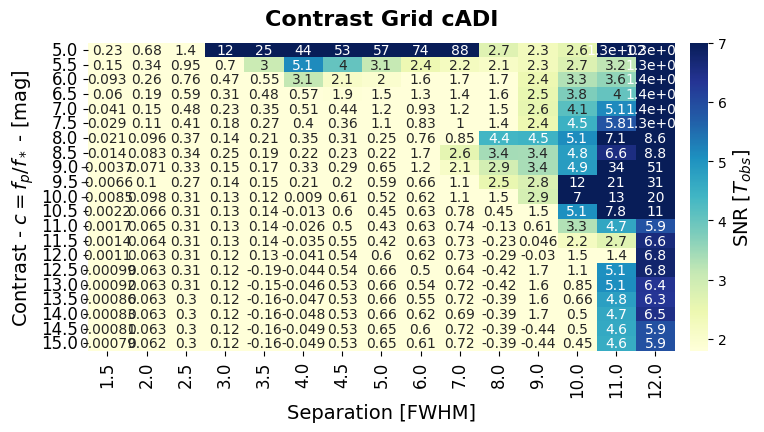

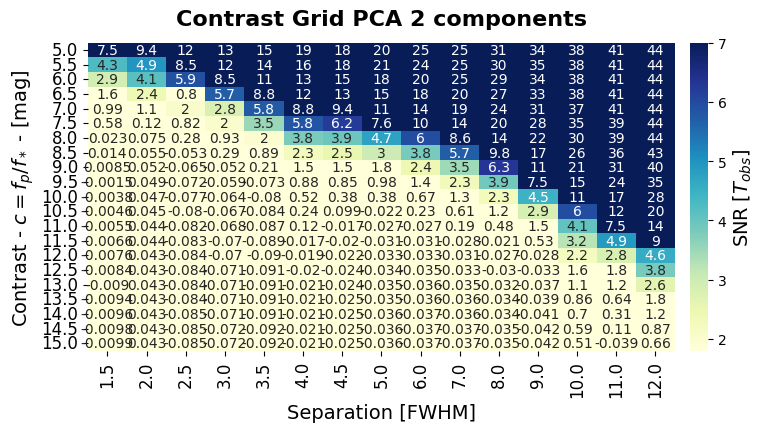

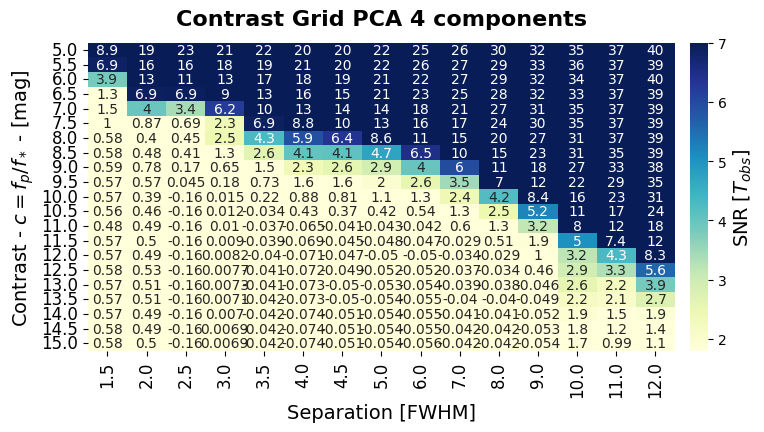

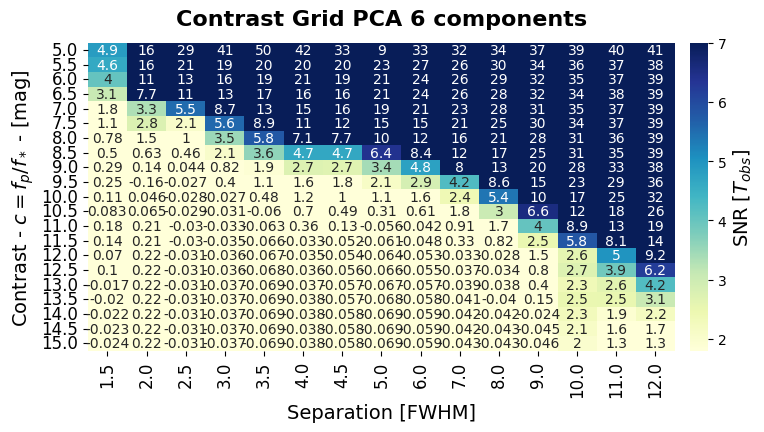

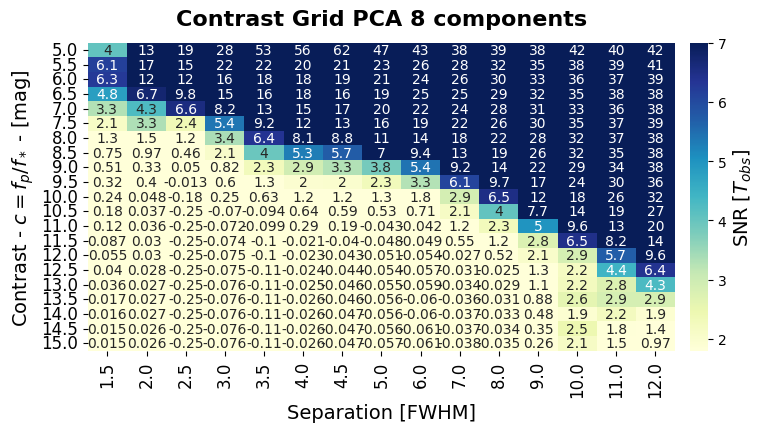

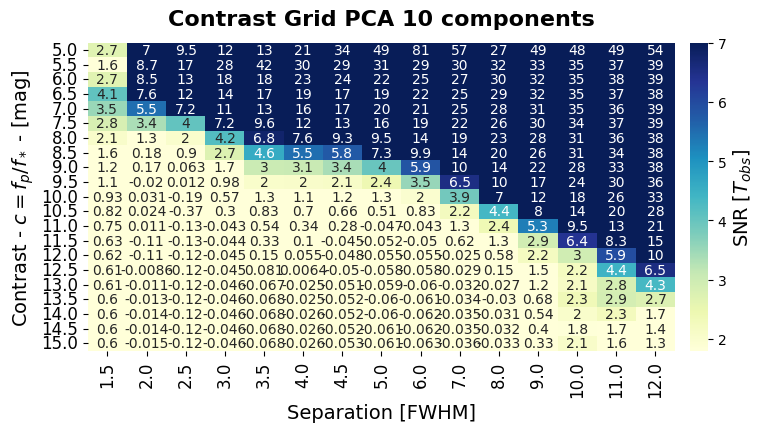

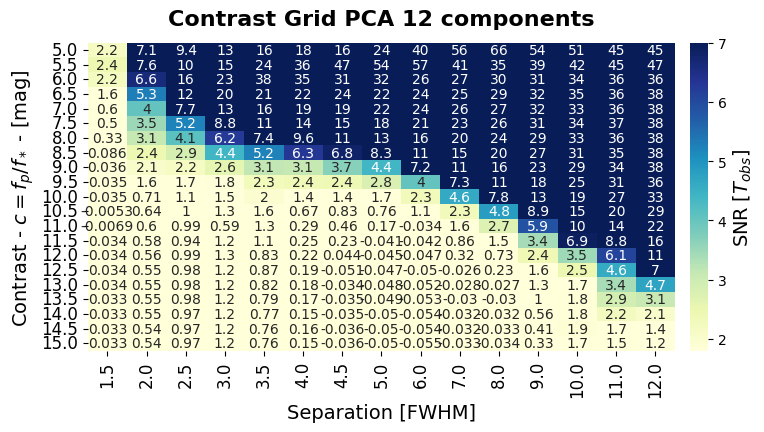

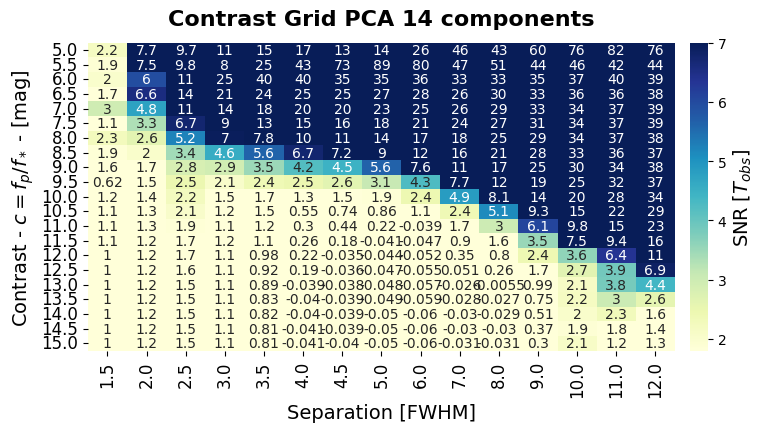

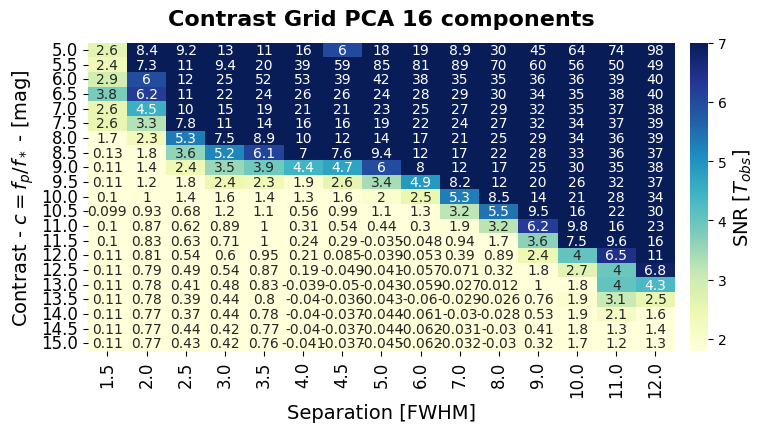

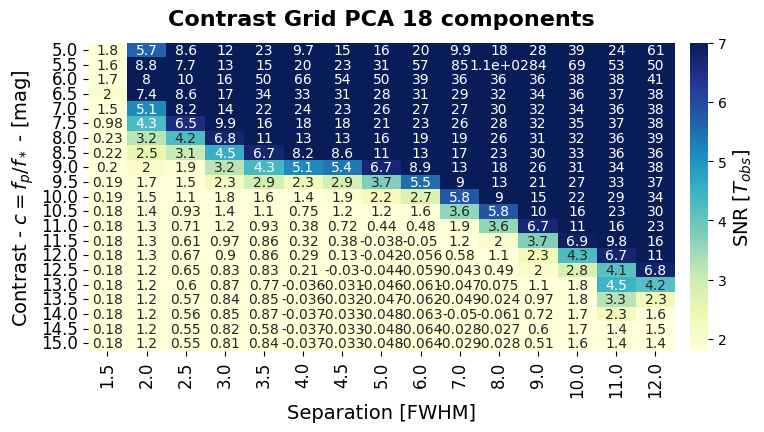

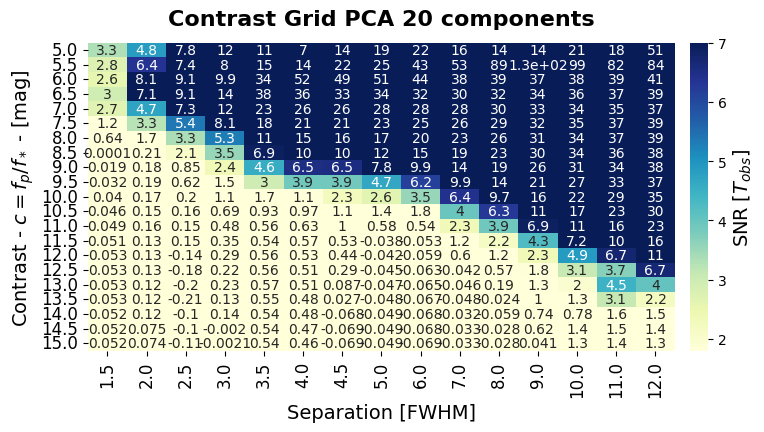

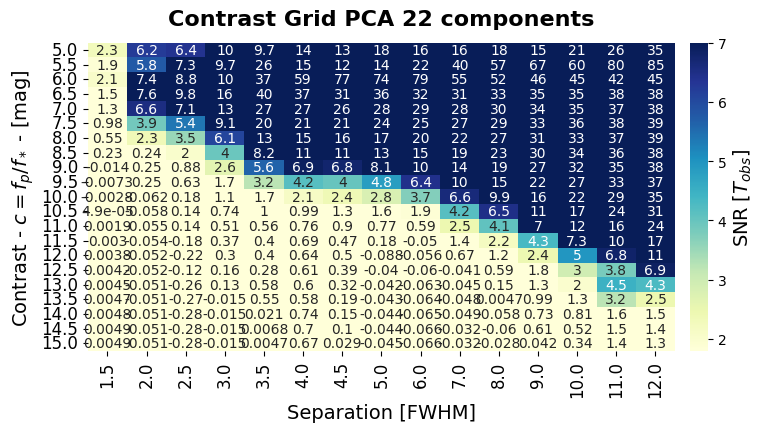

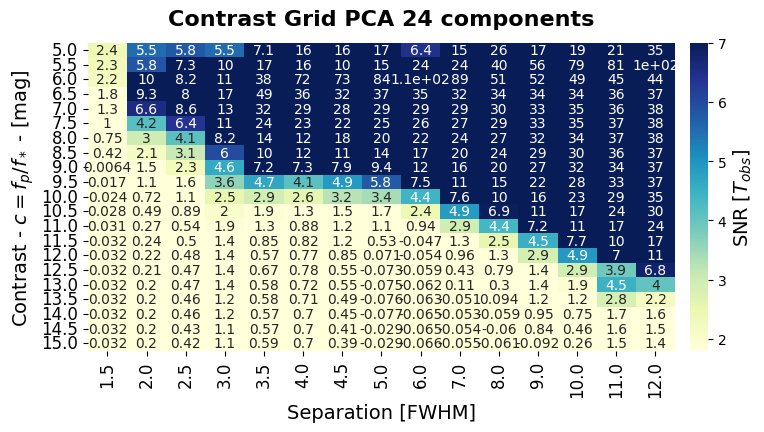

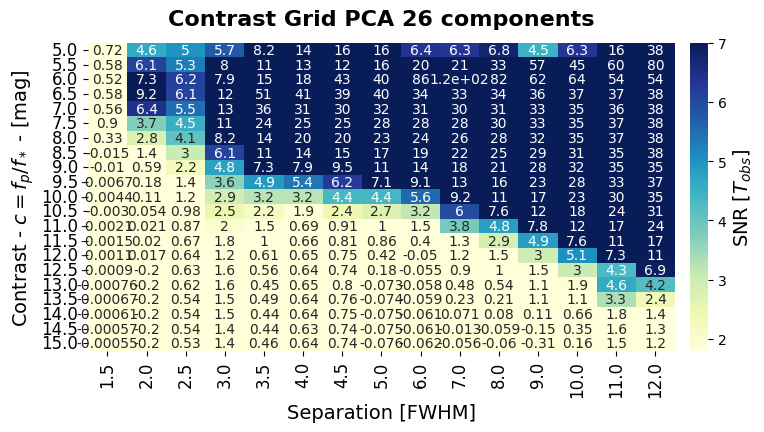

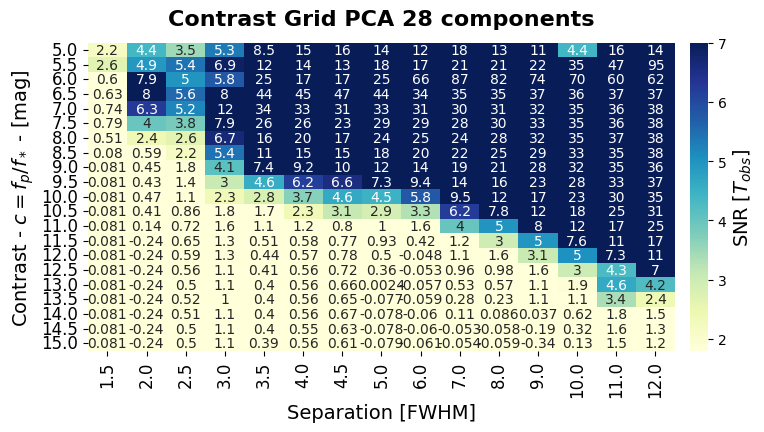

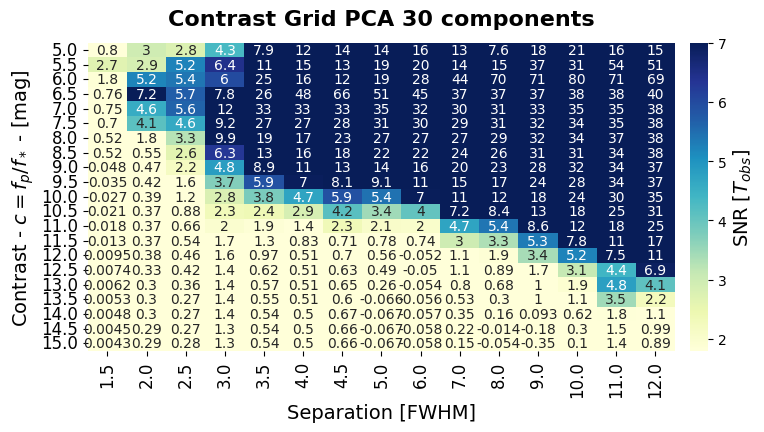

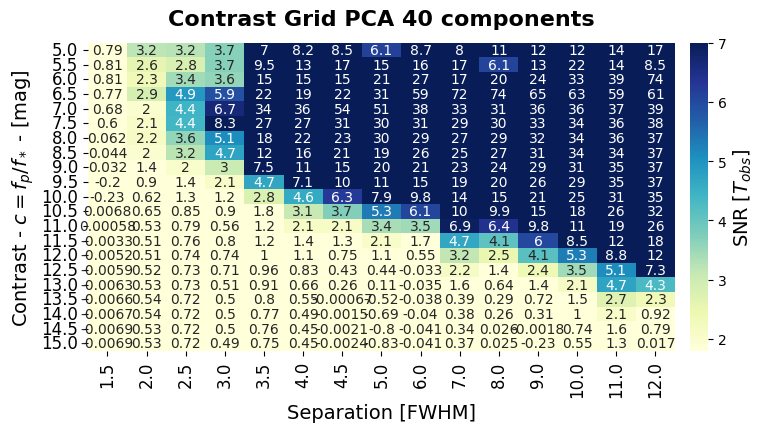

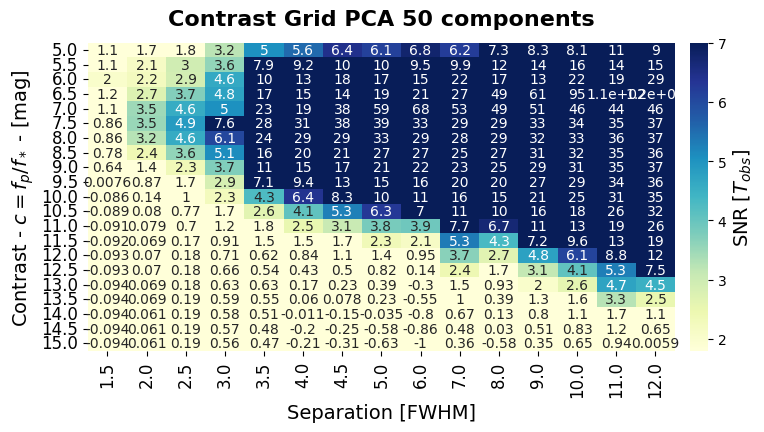

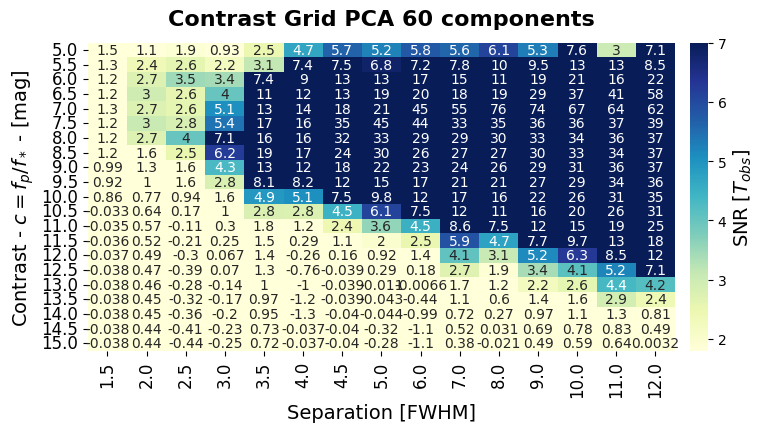

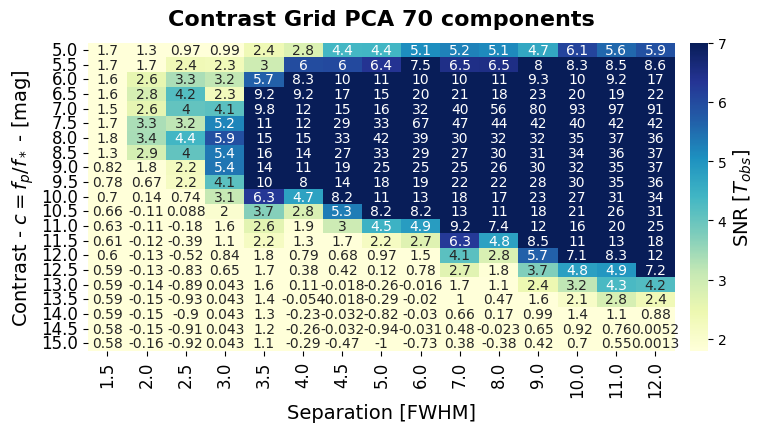

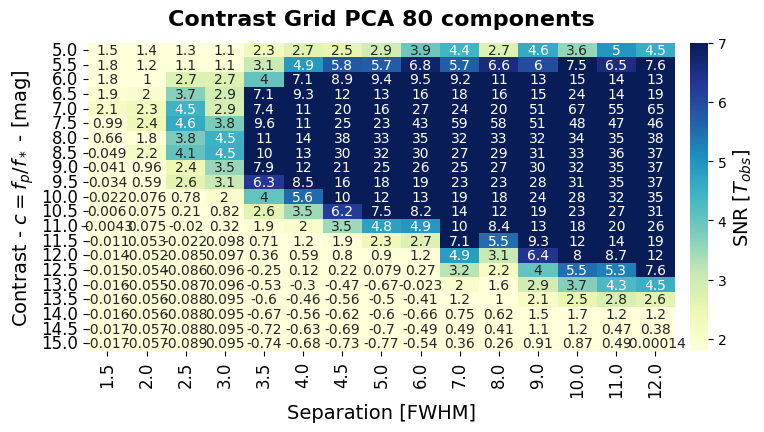

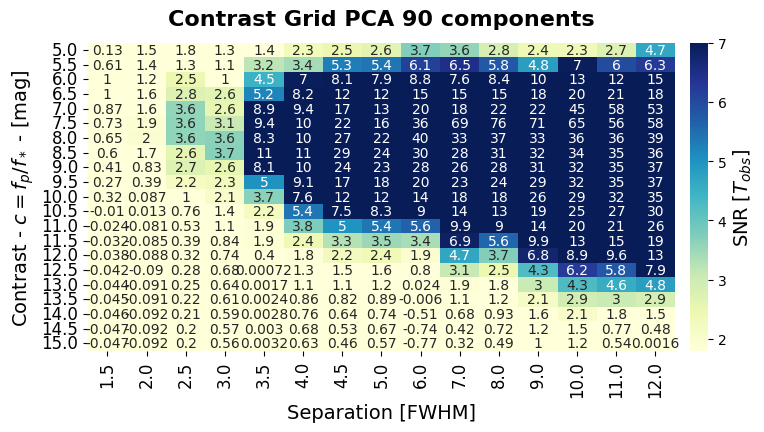

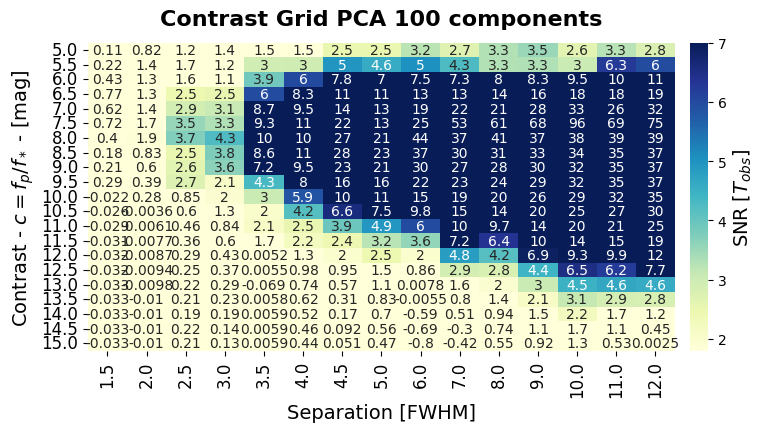

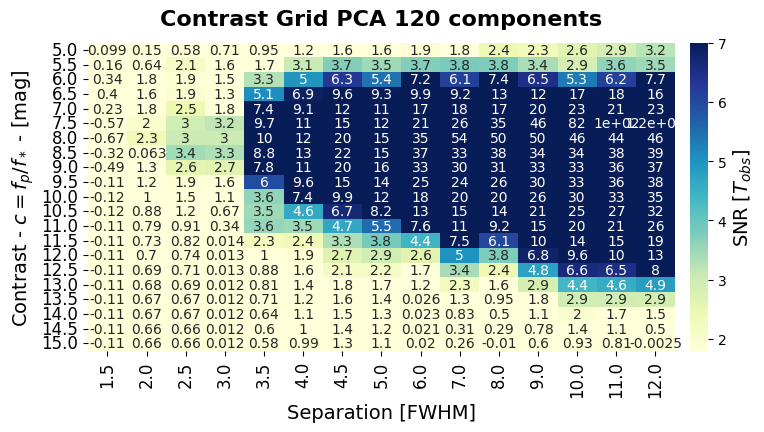

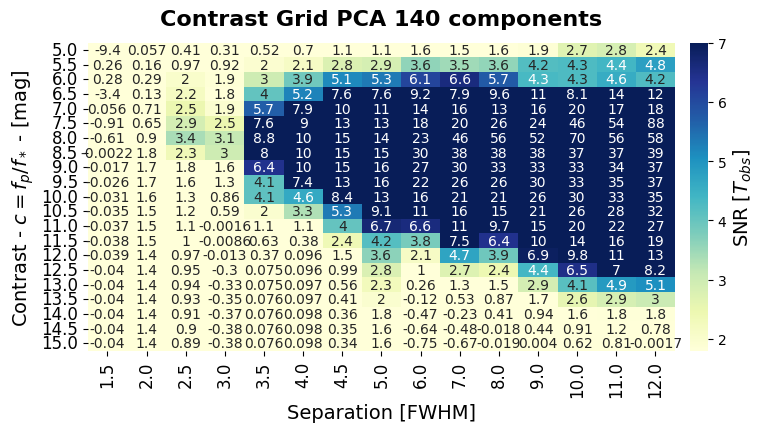

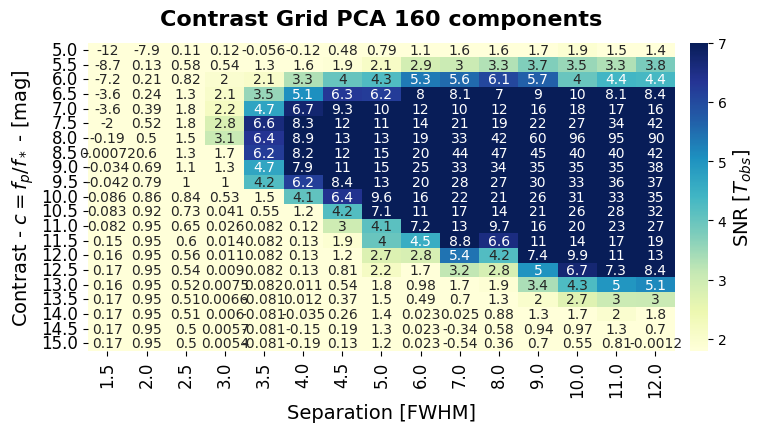

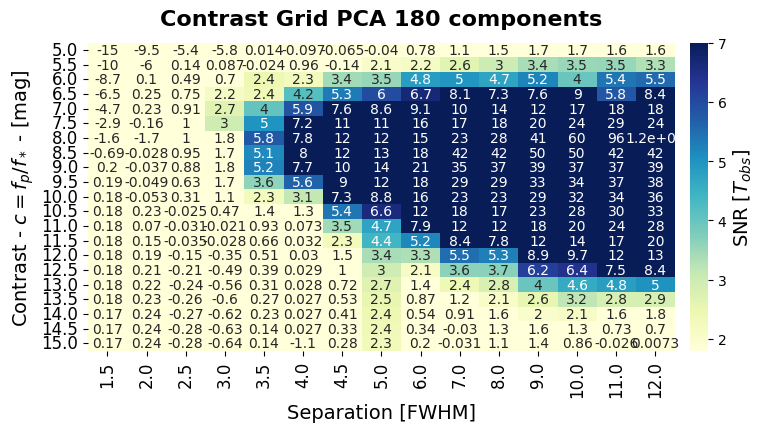

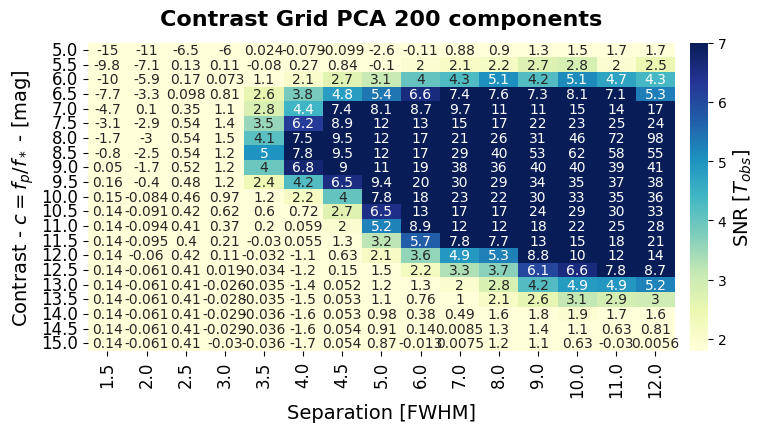

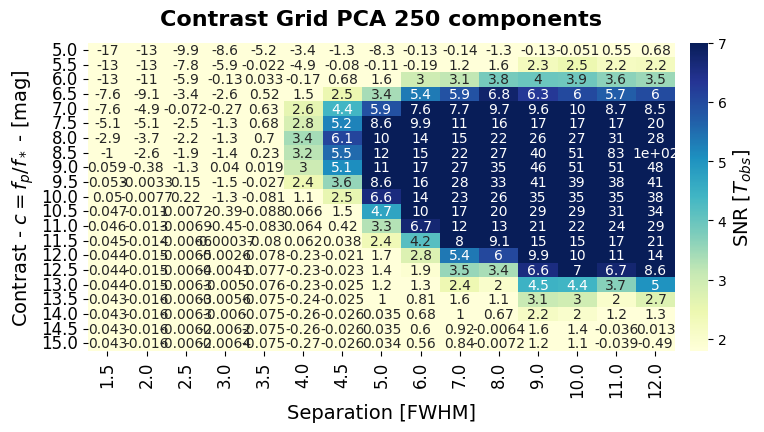

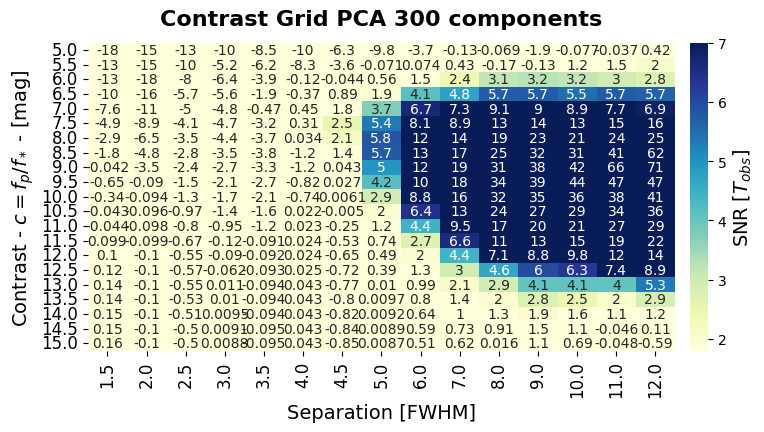

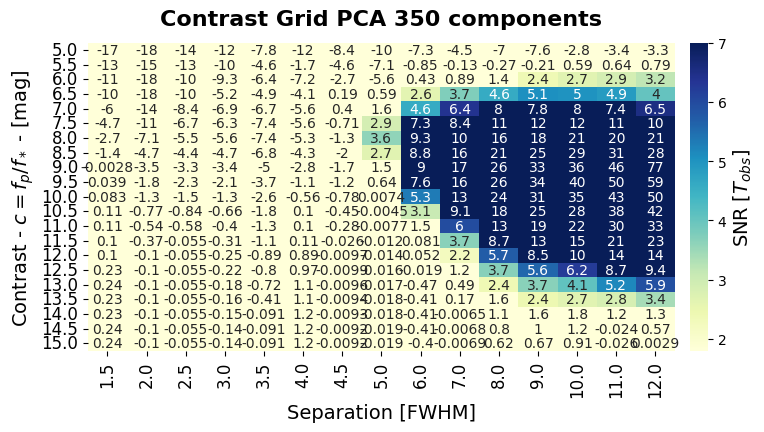

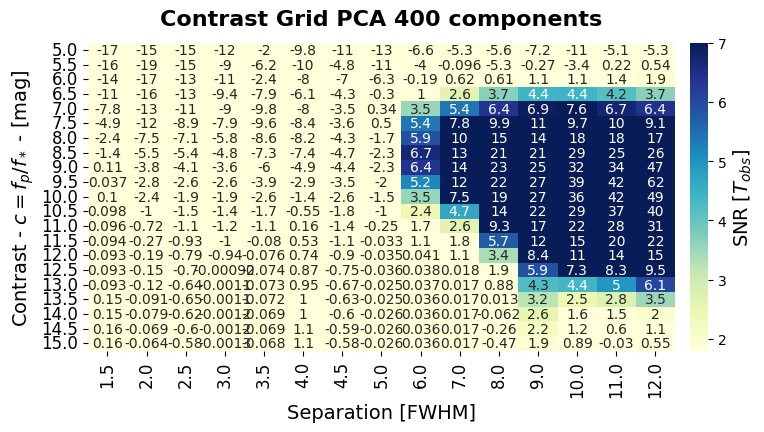

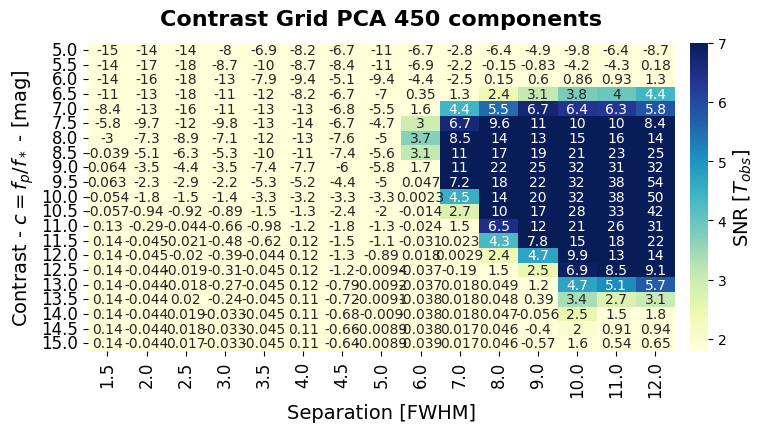

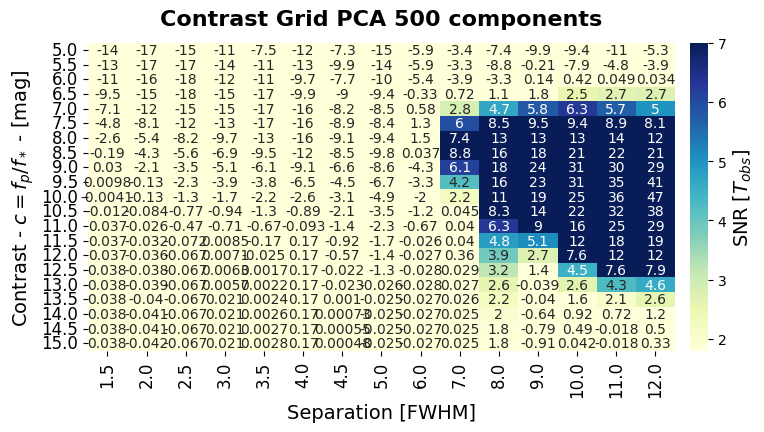

In [63]:
for tmp_model, model_name in [
    ("cADI", "cADI"),
    ("stacked_05_PCA_002_components", "PCA 2 components"),
    ("stacked_05_PCA_004_components", "PCA 4 components"),
    ("stacked_05_PCA_006_components", "PCA 6 components"),
    ("stacked_05_PCA_008_components", "PCA 8 components"),
    ("stacked_05_PCA_010_components", "PCA 10 components"),
    ("stacked_05_PCA_012_components", "PCA 12 components"),
    ("stacked_05_PCA_014_components", "PCA 14 components"),
    ("stacked_05_PCA_016_components", "PCA 16 components"),
    ("stacked_05_PCA_018_components", "PCA 18 components"),
    ("stacked_05_PCA_020_components", "PCA 20 components"),
    ("stacked_05_PCA_022_components", "PCA 22 components"),
    ("stacked_05_PCA_024_components", "PCA 24 components"),
    ("stacked_05_PCA_026_components", "PCA 26 components"),
    ("stacked_05_PCA_028_components", "PCA 28 components"),
    ("stacked_05_PCA_030_components", "PCA 30 components"),
    ("stacked_05_PCA_040_components", "PCA 40 components"),
    ("stacked_05_PCA_050_components", "PCA 50 components"),
    ("stacked_05_PCA_060_components", "PCA 60 components"),
    ("stacked_05_PCA_070_components", "PCA 70 components"),
    ("stacked_05_PCA_080_components", "PCA 80 components"),
    ("stacked_05_PCA_090_components", "PCA 90 components"),
    ("stacked_05_PCA_100_components", "PCA 100 components"),
    ("stacked_05_PCA_120_components", "PCA 120 components"),
    ("stacked_05_PCA_140_components", "PCA 140 components"),
    ("stacked_05_PCA_160_components", "PCA 160 components"),
    ("stacked_05_PCA_180_components", "PCA 180 components"),
    ("stacked_05_PCA_200_components", "PCA 200 components"),
    ("stacked_05_PCA_250_components", "PCA 250 components"),
    ("stacked_05_PCA_300_components", "PCA 300 components"),
    ("stacked_05_PCA_350_components", "PCA 350 components"),
    ("stacked_05_PCA_400_components", "PCA 400 components"),
    ("stacked_05_PCA_450_components", "PCA 450 components"),
    ("stacked_05_PCA_500_components", "PCA 500 components")]:

    s4_contrast_grid = deepcopy(contrast_grids[tmp_model])
    s4_contrast_grid.index = flux_ratio2mag(s4_contrast_grid.index)
    #s4_contrast_grid = s4_contrast_grid.applymap(fpf_2_gaussian_sigma)

    fig = plt.figure(figsize=(8, 4))

    gs0 = fig.add_gridspec(1, 1)
    gs0.update(wspace=0.0, hspace=0.2)
    gs1 = gridspec.GridSpecFromSubplotSpec(
        1, 2, subplot_spec = gs0[0],
        wspace=0.05, width_ratios=[1, 0.03])

    # All axis we need
    contrast_ax = fig.add_subplot(gs1[0])
    colorbar_ax = fig.add_subplot(gs1[1])

    # Plot the contrast grid
    plot_contrast_grid(
        contrast_grid_axis=contrast_ax,
        colorbar_axis=colorbar_ax,
        contrast_grid=s4_contrast_grid)

    colorbar_ax.yaxis.label.set_size(14)

    contrast_ax.set_ylabel(
        "Contrast - $c = f_p / f_*$ - [mag]", size=14)
    contrast_ax.set_xlabel(
        r"Separation [FWHM]", size=14)
    contrast_ax.set_title(
        "Contrast Grid " + model_name,
        fontsize=16,
        fontweight="bold",
        y=1.03)

    contrast_ax.tick_params(
        axis='both',
        which='major',
        labelsize=12)

    # Save the figure
    fig.patch.set_facecolor('white')
    plt.show()